<a href="https://colab.research.google.com/github/ChrysKoum/3th-Assignment/blob/main/Another_copy_of_%CE%91%CE%BD%CF%84%CE%AF%CE%B3%CF%81%CE%B1%CF%86das%CE%BF_%CF%84%CE%BF%CF%85_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
filename = "wind_def_2022.txt"
data = pd.read_csv(filename, sep="\s+", header=0)
print(data);

        2022    1   0  0.1  -4.29  3.86  -3.60  99999.9  999.99   9999999.
0       2022    1   0    1  -4.12  3.90  -3.75    397.8    8.14    98453.0
1       2022    1   0    2  -4.27  3.89  -3.63    397.8    8.14    98453.0
2       2022    1   0    3  -4.55  3.78  -3.39  99999.9  999.99  9999999.0
3       2022    1   0    4  -4.39  3.87  -3.55    393.3    7.65    87638.0
4       2022    1   0    5  -4.65  3.63  -3.45    393.3    7.65    87638.0
...      ...  ...  ..  ...    ...   ...    ...      ...     ...        ...
527034  2022  365  23   55  -4.28  3.02   0.74    569.6    2.91    86049.0
527035  2022  365  23   56  -3.90  3.58  -0.01    573.9    2.71    77893.0
527036  2022  365  23   57  -3.14  3.93   0.48    586.3    2.88    90625.0
527037  2022  365  23   58  -4.20  2.75  -0.24    563.3    2.33    54870.0
527038  2022  365  23   59  -4.16  2.61  -0.03    568.9    2.25    66022.0

[527039 rows x 10 columns]


In [ ]:
 data = pd.read_csv(filename, sep="\s+", header=0)import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data
def load_data(filename):
    data = pd.read_csv(filename, sep="\s+", header=0)
    data['Time'] = pd.to_datetime(data[['Year', 'Month', 'day', 'Hour','Minute']])
    data = data.drop_duplicates()
    return data


In [ ]:
def MR_analysis(data, column_name, window_size=30, cool_down_period=40, color_map=None):
    # Apply changes to data
    data[f'{column_name}_change'] = data[column_name].diff().apply(lambda x: 1 if x != 0 else 0)
    data[f'{column_name}_smoothed'] = data[column_name].rolling(window=window_size).mean()

    # Calculate the 99th percentile of the smoothed Bz component for the upper threshold
    # and 1st percentile for the lower threshold
    if column_name=='Bz':
      upper_powerful_threshold = data[f'{column_name}_smoothed'].quantile(0.95)
      lower_powerful_threshold = data[f'{column_name}_smoothed'].quantile(0.05)
      data[f'{column_name}_potential_MR'] = data[f'{column_name}_smoothed'].apply(lambda x: 1 if x > upper_powerful_threshold or x < lower_powerful_threshold else 0)  # Identify powerful MR events
    else:
      upper_powerful_threshold = data[f'{column_name}_smoothed'].quantile(0.95)
      data[f'{column_name}_potential_MR'] = data[f'{column_name}_smoothed'].apply(lambda x: 1 if x > upper_powerful_threshold  else 0)  # Identify powerful MR events

    last_event_index = None
    for idx, row in data.iterrows():
        if last_event_index is not None and (idx - last_event_index) < cool_down_period:
            data.at[idx, f'{column_name}_potential_MR'] = 0
        elif row[f'{column_name}_potential_MR'] == 1:
            last_event_index = idx

    count_ones = data[f'{column_name}_potential_MR'].sum()

    # Print the count
    print(f'Number of potential MR for {column_name}: {count_ones}')
    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(data['Time'], data[f'{column_name}_smoothed'], label=f'Smoothed {column_name} Component', color=color_map[column_name], alpha=0.8)
    plt.axhline(y=upper_powerful_threshold, color='black', linestyle='-.', linewidth=1.2, label=f'Upper {column_name} Threshold')
    if column_name=='Bz':
      plt.axhline(y=lower_powerful_threshold, color='black', linestyle='-.', linewidth=1.2, label=f'Lower {column_name} Threshold')
    plt.title(f'Smoothed {column_name} Component with Potential MR Events Highlighted (With Cool-down)')
    plt.xlabel('Time Index')
    plt.ylabel(f'{column_name} Value')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    return data[f'{column_name}_potential_MR'].tolist()

Number of potential MR for Bz: 1706


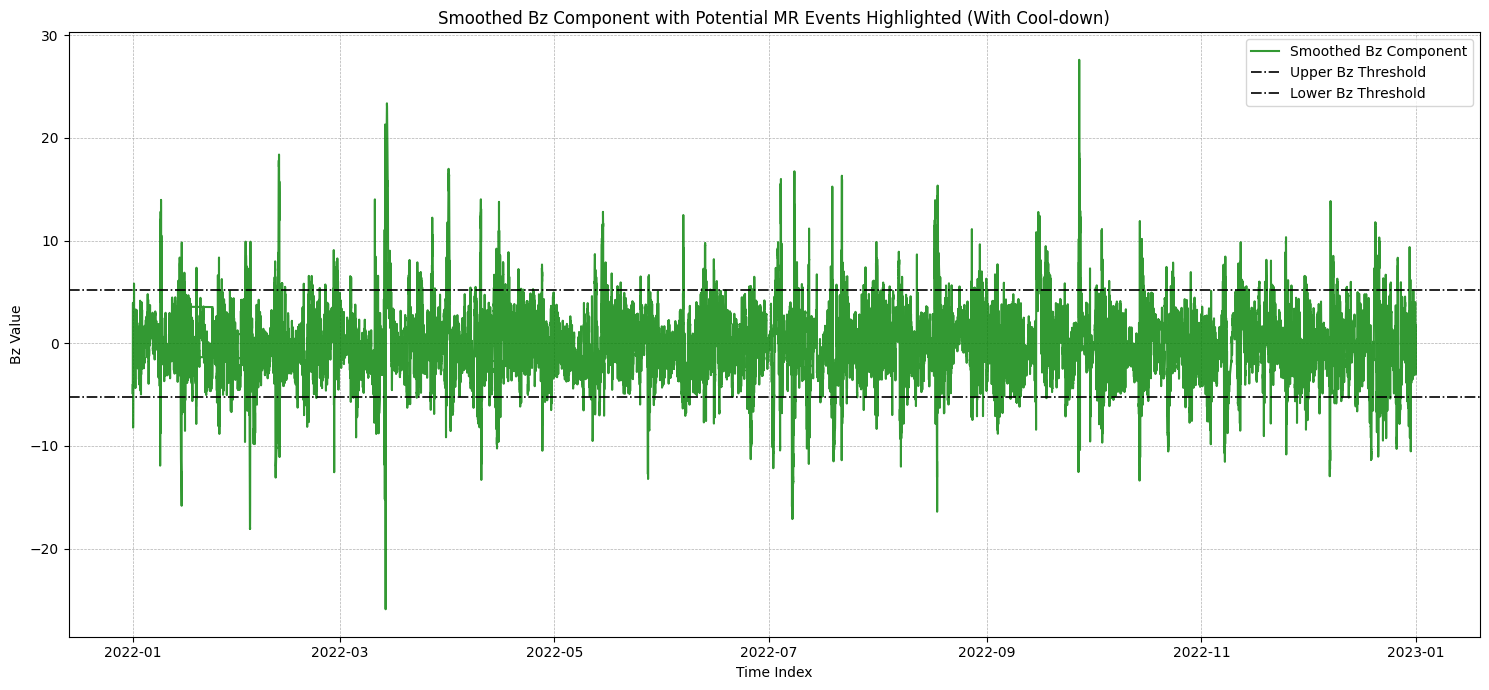

Number of potential MR for Flow_Speed: 758


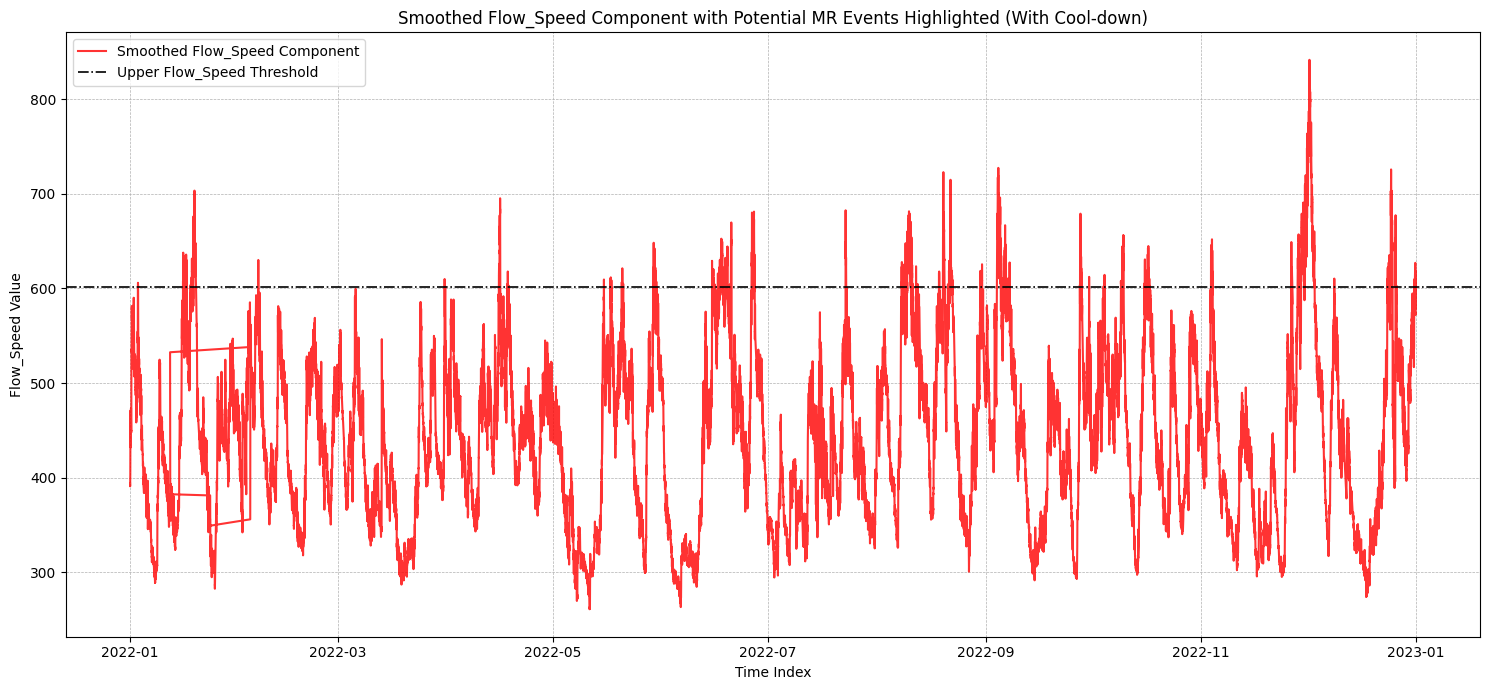

Number of potential MR for Proton_Density: 746


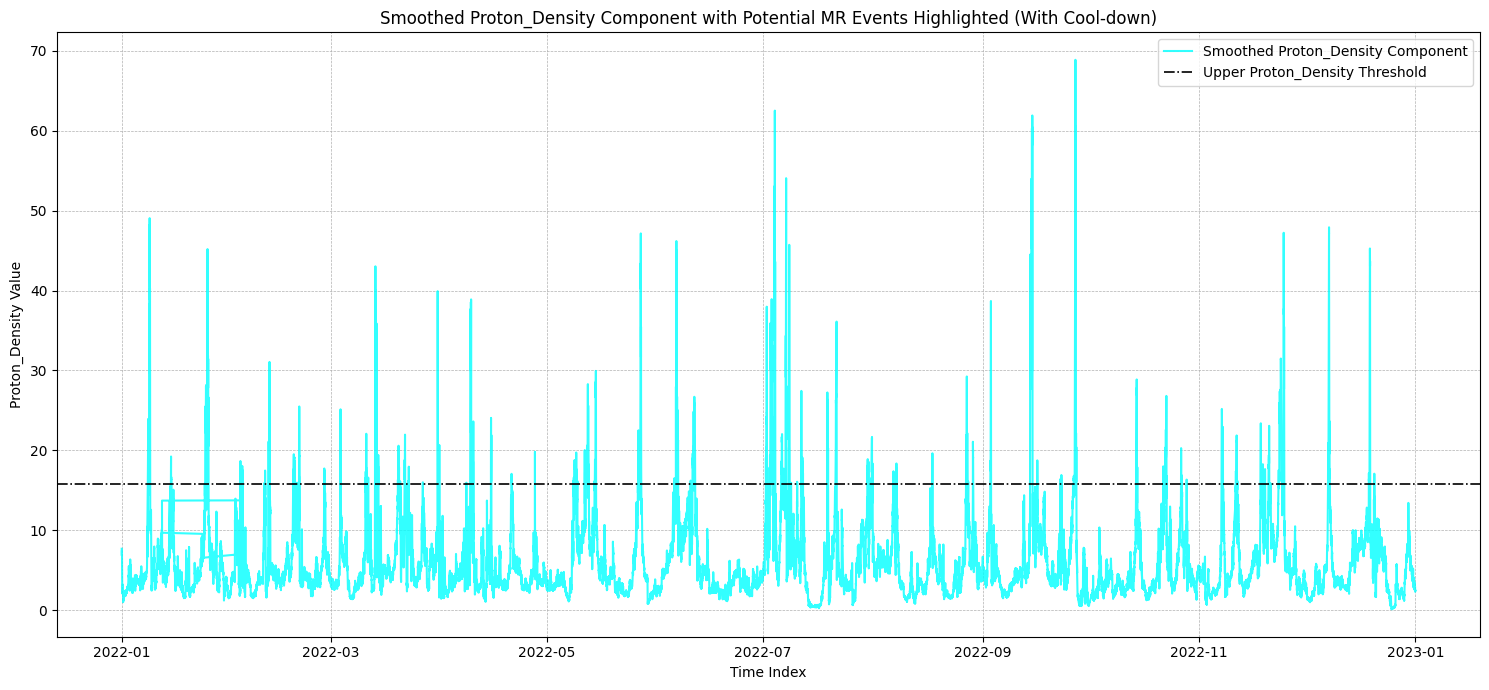

Number of potential MR for Temperature: 785


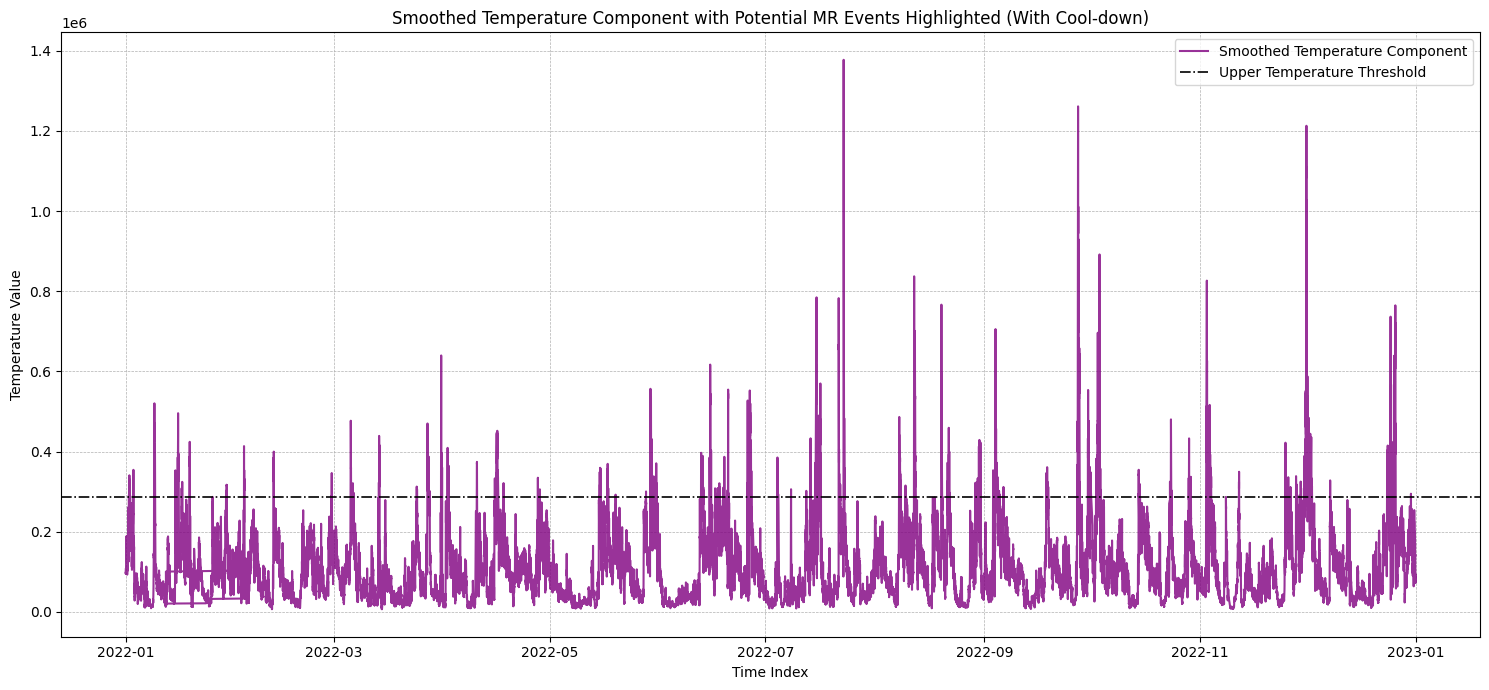

s


In [ ]:
data = load_data("wind_def_2022_clean_month_plus.txt")

color_map = {
    'Bz': 'green',
    'Flow_Speed': 'red',
    'Proton_Density': 'cyan',
    'Temperature': 'purple'
}

potential_MR_flags = {}
for col in ['Bz', 'Flow_Speed', 'Proton_Density', 'Temperature']:
    potential_MR_flags[col] = MR_analysis(data, col, color_map=color_map)

five_day_window = 31 * 24 * 60  # Assuming the data is in minutes resolution
print("s")
for i in range(len(data) - five_day_window):
    if all([potential_MR_flags[col][i] for col in ['Bz', 'Flow_Speed', 'Proton_Density', 'Temperature']]):
        print(f"Magnetic Reconnection likely occurred on {data['Time'].iloc[i]} as spikes detected in all variables within a 5-day window.")
